In [1]:
# ..........torch imports............
import torch

from typing import Tuple
from torch import Tensor

import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

from captum.concept import TCAV
from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str

import numpy as np
import os, glob
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import ttest_ind
import zipfile

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [2]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)

In [3]:
def load_image_tensors_from_zip_file(folder_name, zip_file, transforming=True):
    tensors = []
    for image in images_from_folder_name(folder_name, zip_file):
        with zip_file.open(image) as image_file:
            img = Image.open(image_file).convert('RGB')
            tensors.append(torch.Tensor(transform(img)) if transforming else img)
    return tensors
                
#zip_file = zipfile.ZipFile("Concepts/tiger.zip", "r")
#load_image_tensors_from_zip_file(zip_file)

In [4]:
def assemble_concept_from_tensors(tensors, name, id):
    return Concept(id=id, name=name, data_iter=dataset_to_dataloader(tensors))

In [5]:
#concepts_path = "Concepts/"
#
#stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
#zigzagged_concept = assemble_concept("honeycombed", 1, concepts_path=concepts_path)
#
#random_0_concept = assemble_concept("random_1", 2, concepts_path=concepts_path)
#random_1_concept = assemble_concept("random_2", 3, concepts_path=concepts_path)
#concept_zip = zipfile.ZipFile("Concepts/striped.zip", "r")
#concept_name = concept_zip.filename.split('.')[0]
#random_zip = zipfile.ZipFile("Concepts/random_1.zip", "r")
#random_name = random_zip.filename.split('.')[0]
#class_zip = zipfile.ZipFile("Concepts/tiger.zip", "r")
#class_name = class_zip.filename.split('.')[0]


In [6]:
import zipfile
from PIL import Image


def images_from_folder_name(folder_name, zip_file):
    class_images = []
    # Find the folder with the name "class"
    for name in zip_file.namelist():
        if folder_name in name:
            class_images.append(name)
        
    return class_images
# Example usage
zip_file_path = 'Concepts.zip'
zip_file = zipfile.ZipFile(zip_file_path, 'r')
a = images_from_folder_name("concept", zip_file)
#print(a)

In [7]:
import zipfile

def extract_names_from_zip_folder(zip_file_path):
    class_name = set()
    concept_names = set()
    random_names = set()
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        folder_names = set()
        for name in zip_ref.namelist():
            folder_name = name.split('/')[0]
            if "class" in folder_name:
                class_name.add(folder_name)
            elif "concept" in folder_name:
                concept_names.add(folder_name)
            elif "random" in folder_name:
                random_names.add(folder_name)

    return (list(class_name), list(concept_names), list(random_names))

def make_randoms_tensor_dict(randoms, zip_file):
    tensors = list()
    for folder_name in randoms:
        tensor = load_image_tensors_from_zip_file(folder_name, zip_file)
        tensors.append(tensor)
    return dict(zip(randoms, tensors))

def make_concepts_tensor_dict(concepts, zip_file):
    tensors = list()
    for folder_name in concepts:
        tensor = load_image_tensors_from_zip_file(folder_name, zip_file)
        tensors.append(tensor)
    return dict(zip(concepts, tensors))


In [8]:
class_name, concept_names, randoms = extract_names_from_zip_folder(zip_file_path)
random_tensor_dict = make_randoms_tensor_dict(randoms, zip_file)
concept_tensor_dict = make_concepts_tensor_dict(concept_names, zip_file)

In [9]:
#concept_tensor_dict

In [10]:
# stripes and random
concepts = {concept_name: assemble_concept_from_tensors(concept_tensor_dict[concept_name], concept_name, i) for (i,concept_name) in enumerate(concept_names)}
random_concepts = {random: assemble_concept_from_tensors(random_tensor_dict[random], random, i+len(concept_tensor_dict)) for (i,random) in enumerate(randoms)}

# tiger
#class_tensors = load_image_tensors_from_zip_file(class_zip)
#print(class_tensors)
#test = load_image_tensors("tiger", root_path='Concepts/Concepts_unzipped/')
#class_tensors_tupel = tuple(class_tensors)
#type(class_tensors_tupel)
#type(torch.stack(class_tensors, dim=0))

#type(class_tensors[0])
concepts

{'striped_concept': Concept(0, 'striped_concept'),
 'zigzagged_concept': Concept(1, 'zigzagged_concept'),
 'dotted_concept': Concept(2, 'dotted_concept')}

In [11]:
model = torchvision.models.googlenet(pretrained=True)
model = model.eval()

C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
layer_name = 'inception4c'
layers=[layer_name]

mytcav = TCAV(model=model,
              layers=layers,
              layer_attr_method = LayerIntegratedGradients(
                model, None, multiply_by_inputs=False))

C:\Users\User\anaconda3\lib\site-packages\captum\concept\_utils\classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstract class
  warnings.warn(


In [13]:
experimental_set_rand = [[concepts['dotted_concept'], random_concepts[random]] for random in randoms]
experimental_set_rand

[[Concept(2, 'dotted_concept'), Concept(3, 'random500_7')],
 [Concept(2, 'dotted_concept'), Concept(4, 'random500_2')],
 [Concept(2, 'dotted_concept'), Concept(5, 'random500_6')],
 [Concept(2, 'dotted_concept'), Concept(6, 'random500_3')],
 [Concept(2, 'dotted_concept'), Concept(7, 'random500_5')],
 [Concept(2, 'dotted_concept'), Concept(8, 'random500_9')],
 [Concept(2, 'dotted_concept'), Concept(9, 'random500_1')],
 [Concept(2, 'dotted_concept'), Concept(10, 'random500_10')],
 [Concept(2, 'dotted_concept'), Concept(11, 'random500_4')],
 [Concept(2, 'dotted_concept'), Concept(12, 'random500_8')],
 [Concept(2, 'dotted_concept'), Concept(13, 'random500_0')]]

In [14]:
class_tensors = load_image_tensors_from_zip_file(class_name[0], zip_file)

In [15]:
# tiger class index
tiger_ind = 293

tcav_scores = []
for (i, class_tensor) in enumerate(class_tensors):
    tcav_scores_w_random = mytcav.interpret(inputs=class_tensor.unsqueeze(0),
                                            experimental_sets=experimental_set_rand,
                                            target=tiger_ind,
                                            n_steps=5,
                                           )
    tcav_scores.append(tcav_scores_w_random)

C:\Users\User\anaconda3\lib\site-packages\captum\_utils\models\linear_model\train.py:350: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


In [16]:
#tscore = {i: score fo}
concepts_key = concepts_to_str(experimental_set_rand[0])


#mean_tcav_scores = 
#print(tcav_scores[0])
x = 0
def mean_tcav_scores(tcav_scores, expermental_set_rand, layer_name):
    mean_tcav_scores = {}
    for i in range(len(experimental_set_rand)):
        concepts_key = concepts_to_str(experimental_set_rand[i])
        mean_scores = tcav_scores[0][concepts_key].copy()
        mean_sign_count = sum([score[concepts_key][layer_name]['sign_count'] for score in tcav_scores])/len(tcav_scores)
        mean_magnitude = sum([score[concepts_key][layer_name]['magnitude'] for score in tcav_scores])/len(tcav_scores)
        mean_scores[layer_name]['sign_count'] = mean_sign_count
        mean_scores[layer_name]['magnitude'] = mean_magnitude
        mean_tcav_scores[concepts_key] = mean_scores
    return mean_tcav_scores
mean_scores = mean_tcav_scores(tcav_scores, experimental_set_rand, layer_name)

In [17]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

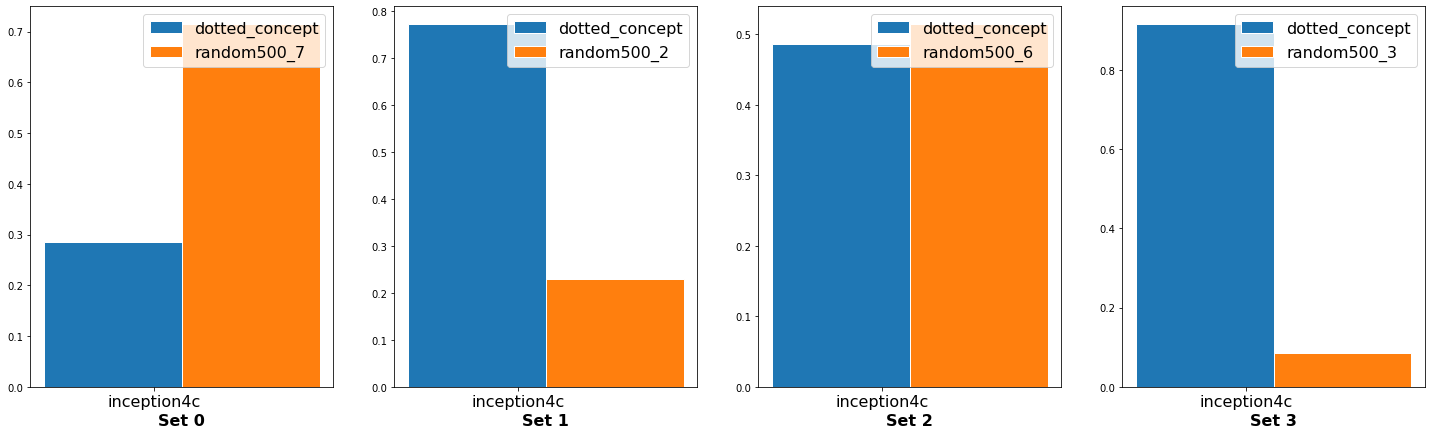

In [18]:
plot_tcav_scores(experimental_set_rand[:4], mean_scores)

In [30]:
experimental_set_zig_dot = [[concepts['dotted_concept'], concepts['zigzagged_concept'], concepts['striped_concept']]]

In [31]:
#tcav_scores_w_zig_dot_stripe = mytcav.interpret(inputs=class_tensor.unsqueeze(0),
#                                         experimental_sets=experimental_set_zig_dot,
#                                         target=tiger_ind,
#                                         n_steps=5)

tcav_scores_w_zig_dot_stripe = []
for (i, class_tensor) in enumerate(class_tensors):
    tcav_scores_w_random = mytcav.interpret(inputs=class_tensor.unsqueeze(0),
                                            experimental_sets=experimental_set_zig_dot,
                                            target=tiger_ind,
                                            n_steps=5,
                                           )
    tcav_scores_w_zig_dot_stripe.append(tcav_scores_w_random)

In [27]:
#def mean_tcav_scores(tcav_scores, expermental_set_rand, layer_name):
#    concepts_key = next(iter(tcav_scores[4]))
#    mean_tcav_scores = {}
#    for i in range(len(experimental_set_rand)):
#        mean_scores = tcav_scores[4][concepts_key].copy()
#        mean_sign_count = sum([score[concepts_key][layer_name]['sign_count'] for score in tcav_scores])/len(tcav_scores)
#        mean_magnitude = sum([score[concepts_key][layer_name]['magnitude'] for score in tcav_scores])/len(tcav_scores)
#        mean_scores[layer_name]['sign_count'] = mean_sign_count
#        mean_scores[layer_name]['magnitude'] = mean_magnitude
#        mean_tcav_scores[concepts_key] = mean_scores
#    return mean_tcav_scores

#tcav_scores_w_zig_dot_stripe = mean_tcav_scores(tcav_scores_w_zig_dot_stripe, experimental_set_rand, layer_name)

{'2-3': defaultdict(None,
             {'inception4c': {'sign_count': tensor([0.2939, 0.7061]),
               'magnitude': tensor([-0.3814,  0.3814])}}),
 '2-4': defaultdict(None,
             {'inception4c': {'sign_count': tensor([0.7649, 0.2351]),
               'magnitude': tensor([ 0.4972, -0.4972])}}),
 '2-5': defaultdict(None,
             {'inception4c': {'sign_count': tensor([0.4996, 0.5004]),
               'magnitude': tensor([-0.1689,  0.1689])}}),
 '2-6': defaultdict(None,
             {'inception4c': {'sign_count': tensor([0.9118, 0.0882]),
               'magnitude': tensor([ 0.5508, -0.5508])}}),
 '2-7': defaultdict(None,
             {'inception4c': {'sign_count': tensor([0.7061, 0.2939]),
               'magnitude': tensor([ 0.2222, -0.2222])}}),
 '2-8': defaultdict(None,
             {'inception4c': {'sign_count': tensor([0.8531, 0.1469]),
               'magnitude': tensor([ 0.8305, -0.8305])}}),
 '2-9': defaultdict(None,
             {'inception4c': {'sign_count': 

TypeError: list indices must be integers or slices, not str

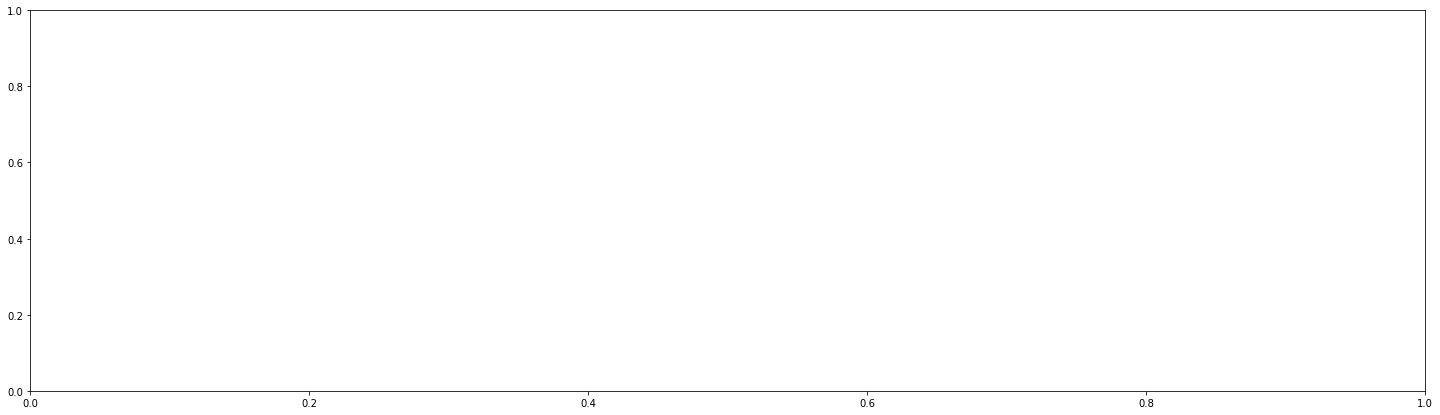

In [32]:
plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot_stripe)    

In [ ]:
def get_exp_set_for_p_value(concept, random_concepts):
    l1 = [[concept, random_concept] for random_concept in random_concepts]
    l2 = [[random_concepts[randoms[0]], random_concepts[randoms[i]]] for i in range(1, len(random_concepts))]
    l1.extend(l2)
    return l1

experimental_sets = get_exp_set_for_p_value(concepts['dotted_concept'], random_concepts)

experimental_sets

In [ ]:
def assemble_scores(scores, experimental_sets, idx, score_layer, score_type):
    score_list = []
    for concepts in experimental_sets:
        score_list.append(scores["-".join([str(c.id) for c in concepts])][score_layer][score_type][idx])
        
    return score_list

In [ ]:
def get_pval(scores, experimental_sets, score_layer, score_type, alpha=0.05, print_ret=False):
    
    P1 = assemble_scores(scores, experimental_sets, 0, score_layer, score_type)
    P2 = assemble_scores(scores, experimental_sets, 1, score_layer, score_type)
    
    if print_ret:
        print('P1[mean, std]: ', format_float(np.mean(P1)), format_float(np.std(P1)))
        print('P2[mean, std]: ', format_float(np.mean(P2)), format_float(np.std(P2)))

    _, pval = ttest_ind(P1, P2)

    if print_ret:
        print("p-values:", format_float(pval))

    if pval < alpha:    # alpha value is 0.05 or 5%
        relation = "Disjoint"
        if print_ret:
            print("Disjoint")
    else:
        relation = "Overlap"
        if print_ret:
            print("Overlap")
        
    return P1, P2, format_float(pval), relation

In [81]:
# Run TCAV
#scores = mytcav.interpret(class_tensor.unsqueeze(0), experimental_sets, tiger_ind, n_steps=5)

tcav_scores = []
for (i, class_tensor) in enumerate(class_tensors):
    tcav_scores_w_random = mytcav.interpret(inputs=class_tensor.unsqueeze(0),
                                            experimental_sets=experimental_sets,
                                            target=tiger_ind,
                                            n_steps=5,
                                           )
    tcav_scores.append(tcav_scores_w_random)

AttributeError: 'str' object has no attribute 'id'

In [ ]:
scores

In [ ]:
n = 4
def show_boxplots(layer, metric='sign_count'):

    def format_label_text(experimental_sets):
        concept_id_list = [exp.name if i == 0 else \
                             exp.name.split('_')[0] for i, exp in enumerate(experimental_sets[0])]
        return concept_id_list

    n_plots = 2

    fig, ax = plt.subplots(1, n_plots, figsize = (25, 7 * 1))
    fs = 18
    for i in range(n_plots):
        esl = experimental_sets[i * n : (i+1) * n]
        P1, P2, pval, relation = get_pval(scores, esl, layer, metric)

        ax[i].set_ylim([0, 1])
        ax[i].set_title(layer + "-" + metric + " (pval=" + str(pval) + " - " + relation + ")", fontsize=fs)
        ax[i].boxplot([P1, P2], showfliers=True)

        ax[i].set_xticklabels(format_label_text(esl), fontsize=fs)

    plt.show()

In [ ]:
show_boxplots("inception4c")

In [ ]:
show_boxplots ("inception4d")

In [ ]:
show_boxplots ("inception4e")

In [ ]:
get_pval()